In [175]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'

import torch
from torch import nn
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF

import lightning.pytorch as pl

import random
import os
import csv
from pathlib import Path

from PIL import Image

In [176]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


# Load Image

In [177]:
# Setup path to data folder
from pathlib import Path
image_path = Path("data/IMG/")

# Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("center_*.jpg"))

# Get random image path
# random.seed(42)
random_image_path = random.choice(image_path_list)

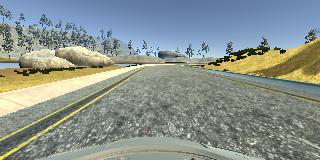

In [178]:
# Open image
image = Image.open(random_image_path)
image

# Transform Explore

In [179]:
print(f"Image height: {image.height}") 
print(f"Image width: {image.width}")

Image height: 160
Image width: 320


In [180]:
# gray_image = TF.rgb_to_grayscale(image)
# gray_image

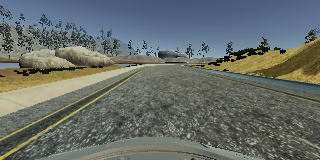

In [181]:
jitter = T.ColorJitter(brightness=.5, hue=.3, contrast=0.1, saturation=0.4)
jittered_image = jitter(image)
jittered_image

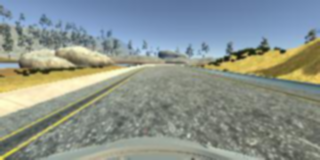

In [182]:
blurred_image = TF.gaussian_blur(image, kernel_size=5)
blurred_image

In [183]:
# gray_image = TF.rgb_to_grayscale(image)
# gray_image

# Preprocessing Images

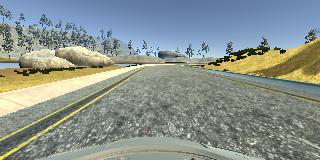

In [184]:
image

In [185]:
print(f"Image height: {image.height}") 
print(f"Image width: {image.width}")

Image height: 160
Image width: 320


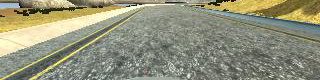

In [186]:
cropped_image = TF.crop(image, 
                       top=60, 
                       left=0, 
                       height=80,
                       width=320)

cropped_image

In [187]:
print(f"Image height: {cropped_image.height}") 
print(f"Image width: {cropped_image.width}")

Image height: 80
Image width: 320


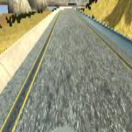

In [188]:
preprocessed_image = TF.resize(cropped_image, (132, 132))
preprocessed_image

In [189]:
# perspective_transformer = T.RandomPerspective(distortion_scale=0.15, p=1.0)
# perspective_transformer(preprocessed_image)

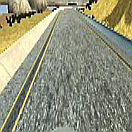

In [190]:
sharpness_adjuster = T.RandomAdjustSharpness(sharpness_factor=4)
sharpness_adjuster(preprocessed_image)

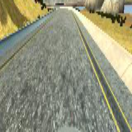

In [191]:
TF.hflip(preprocessed_image)

# Normalization

In [203]:
# does not scale values to 0 and 1
tensor_image = T.PILToTensor()(preprocessed_image) 
tensor_image.shape

torch.Size([3, 132, 132])

In [204]:
y = tensor_image[0]
y

tensor([[144, 147, 141,  ..., 123, 128, 118],
        [129, 129, 123,  ..., 130, 127, 112],
        [107, 102,  98,  ..., 141, 125, 104],
        ...,
        [172, 207, 137,  ...,  92,  87,  92],
        [196, 176, 112,  ..., 100,  92,  97],
        [212, 154,  95,  ..., 106,  96, 101]], dtype=torch.uint8)

In [205]:
y = tensor_image[0] / 127.5 - 1
y

tensor([[ 0.1294,  0.1529,  0.1059,  ..., -0.0353,  0.0039, -0.0745],
        [ 0.0118,  0.0118, -0.0353,  ...,  0.0196, -0.0039, -0.1216],
        [-0.1608, -0.2000, -0.2314,  ...,  0.1059, -0.0196, -0.1843],
        ...,
        [ 0.3490,  0.6235,  0.0745,  ..., -0.2784, -0.3176, -0.2784],
        [ 0.5373,  0.3804, -0.1216,  ..., -0.2157, -0.2784, -0.2392],
        [ 0.6627,  0.2078, -0.2549,  ..., -0.1686, -0.2471, -0.2078]])

In [206]:
y = ( y + 1 ) * 127.5 
y

tensor([[144., 147., 141.,  ..., 123., 128., 118.],
        [129., 129., 123.,  ..., 130., 127., 112.],
        [107., 102.,  98.,  ..., 141., 125., 104.],
        ...,
        [172., 207., 137.,  ...,  92.,  87.,  92.],
        [196., 176., 112.,  ..., 100.,  92.,  97.],
        [212., 154.,  95.,  ..., 106.,  96., 101.]])

In [128]:
from utils import normalize_rgb_get_mean_std
normalized_tensor_image, mean_per_channel, std_per_channel = normalize_rgb_get_mean_std(tensor_image)
mean_per_channel, std_per_channel

(tensor([0.5684, 0.5549, 0.4709]), tensor([0.1382, 0.1202, 0.1245]))

In [129]:
mean_R, mean_G, mean_B = mean_per_channel
std_R, std_G, std_B = std_per_channel

# Transforms

In [173]:
train_transform = T.Compose([
    T.Resize((132, 132)),
    T.RandomCrop((128, 128)),
    T.RandomAdjustSharpness(sharpness_factor=4, p=0.7),
    T.RandomAutocontrast(p=0.7),
    T.ColorJitter(brightness=0.6, hue=0.3, contrast=0.6, saturation=0.6),
    T.GaussianBlur(kernel_size=3),
    T.ToTensor(),
    T.Normalize((mean_R, mean_G, mean_B), (std_R, std_G, std_B)),
])

In [174]:
y = train_transform(preprocessed_image)

from utils import denormalize_rgb
x = denormalize_rgb(y, mean_per_channel, std_per_channel)
x.shape

AttributeError: 'list' object has no attribute 'view'

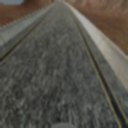

In [133]:
TF.to_pil_image(x)

# Remove Straight Roads

In [134]:
import random

csv_path = '.\data\driving_log.csv'
full_set = []

with open(csv_path, 'r') as csvfile:
    data_reader = csv.reader(csvfile, delimiter=',')

    for row in data_reader:
        if row[3] == '0' and random.random() > 0.1:
            continue
        
        sim_data = {
            'image_center_path': row[0],
            'image_left_path': row[1],
            'image_right_path': row[2],
            'steering_angle': float(row[3]),
        }

        full_set.append(sim_data)

In [135]:
len(full_set)

3100

In [136]:
from collections import Counter

c = Counter()
for sim_data in full_set:
    if sim_data['steering_angle'] == 0:
        c[0] += 1
    else:
        c[1] += 1

c

Counter({0: 907, 1: 2193})

# Read Using TorchVision

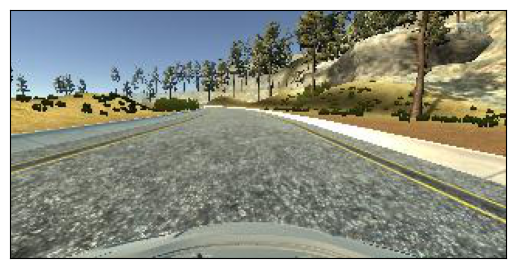

In [141]:
random_image_path = 'data/IMG/center_2019_04_02_19_26_54_083.jpg'
image = torchvision.io.read_image(random_image_path)

from utils import show_tensor_images
show_tensor_images([image])

In [168]:
train_transform = T.Compose([
    T.Resize((132, 132)),
    T.RandomCrop((128, 128)),
    T.RandomAdjustSharpness(sharpness_factor=4, p=0.7),
    T.RandomAutocontrast(p=0.7),
    T.ColorJitter(brightness=0.6, hue=0.3, contrast=0.6, saturation=0.6),
    T.GaussianBlur(kernel_size=3),
])

In [169]:
y = train_transform(image)

In [170]:
# normalize to -1 to 1
y = y / 127.5 - 1

In [171]:
y = ( y + 1 ) * 127.5 

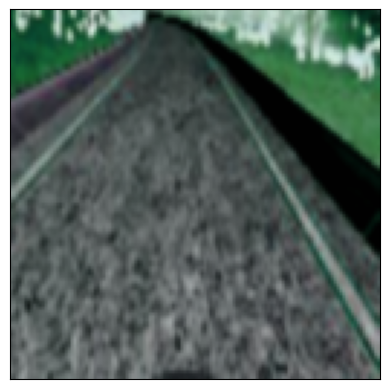

In [172]:
show_tensor_images([y])

In [149]:
from utils import denormalize_rgb
mean_per_channel, std_per_channel = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
x = denormalize_rgb(y, mean_per_channel, std_per_channel)
x.shape

AttributeError: 'list' object has no attribute 'view'